In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# I. Problem 2: Larger unlabeled subset

Now we will work with the larger, unlabeled subset in 'p2\_unsupervised'. This dataset is has not been processed, so you should process \textbf{using the same log transform} as in Problem 1.

## Part 2. Unsupervised Feature Selection

Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the p2_unsupervised dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in p2_evaluation, and run it on the test set in the same folder.

## QUESTION 1
Provide at least on visualization which clearly shows the existence of 3 main brain cell types as described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from different groups can differ greatly.

### 1. Read data

In [2]:
X = np.load('./gene_analysis_data/p2_unsupervised/X.npy')
X.shape

(2169, 45768)

In [3]:
mx = -1
for a in X:
    if a[0] > mx:
        mx = a[0]
mx

61.77721743231262

In [4]:
X.max(axis=0)

array([  61.77721743,    0.        , 1183.63034554, ...,    0.        ,
          0.        ,    0.        ])

### 2. Transform the Data

In [5]:
X = np.apply_along_axis(lambda x: np.log2(x+1), 1, X)

In [6]:
X.max(axis=0)

array([ 5.97216918,  0.        , 10.21022123, ...,  0.        ,
        0.        ,  0.        ])

### 3. Dimensionality Reduction with PCA

In [7]:
# Apply PCA
pca = PCA(n_components=0.80)  # Retain 80% of the variance
X_PCA = pca.fit_transform(X)

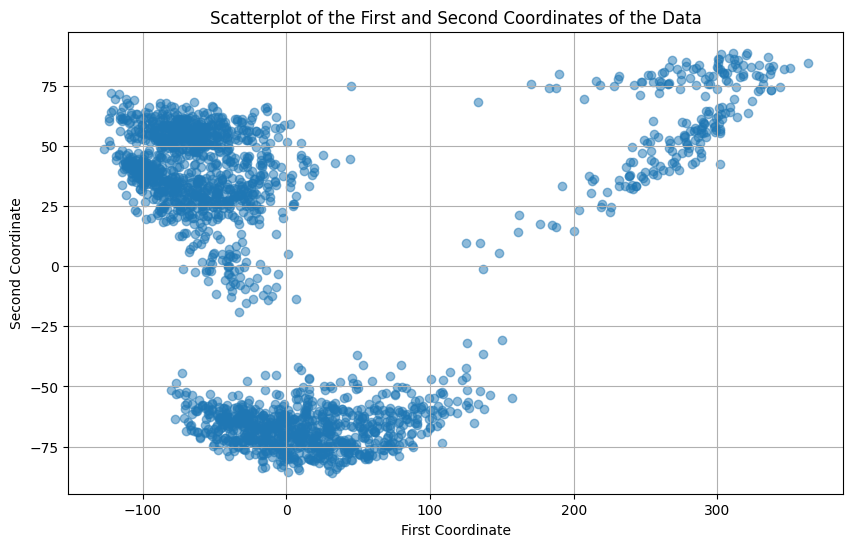

In [8]:
# Extract the first and second coordinates (columns) from the data
x = X_PCA[:, 0]
y = X_PCA[:, 1]

# Create the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('First Coordinate')
plt.ylabel('Second Coordinate')
plt.title('Scatterplot of the First and Second Coordinates of the Data')
plt.grid(True)
plt.show()

### 4. Clustering

In [9]:
from sklearn.manifold import TSNE

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=40, n_iter=2000)
X_TSNE = tsne.fit_transform(X_PCA)

In [10]:
X_TSNE

array([[10.208504 ,  2.4665756],
       [14.680122 , -2.0750787],
       [14.209382 , -1.567431 ],
       ...,
       [52.577034 ,  8.799047 ],
       [52.24452  ,  9.421549 ],
       [52.35249  , 10.314185 ]], dtype=float32)

/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha/.local/lib/python3.10/site-packages/skl

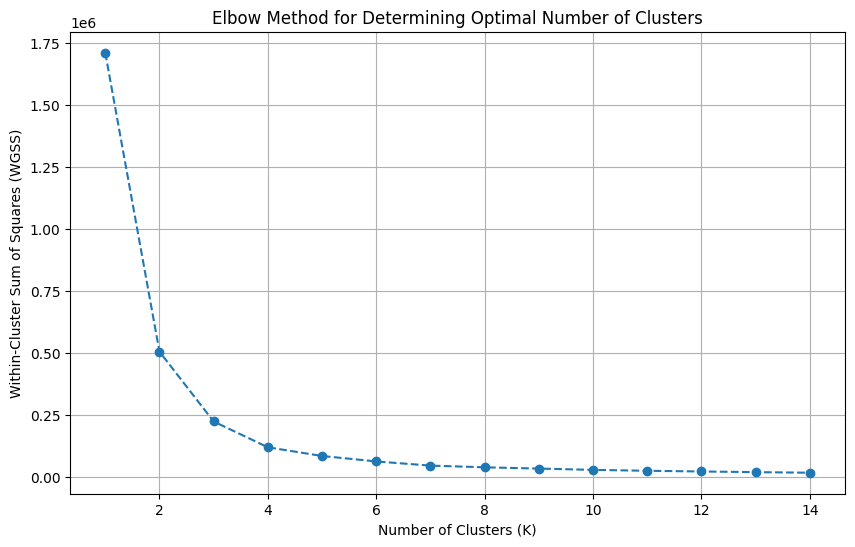

In [11]:
# Range of clusters to try
num_clusters_range = range(1, 15)
wgss = []

# Fit K-Means for each number of clusters and store the WGSS (inertia)
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_TSNE)
    wgss.append(kmeans.inertia_)

# Plot WGSS versus number of clusters
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, wgss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WGSS)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.grid(True)
plt.show()

### 5. Visualize Clusters

/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


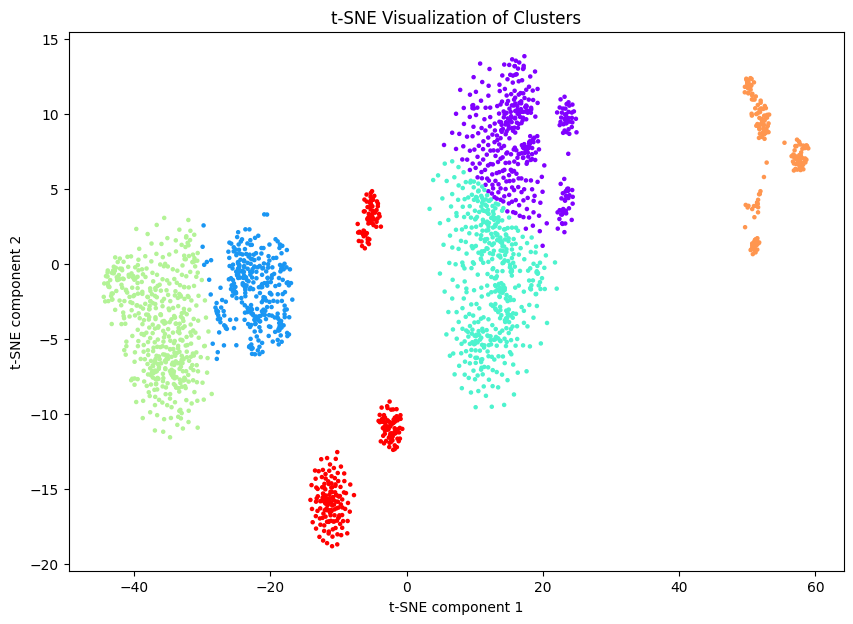

In [12]:
# Apply KMeans with the optimal number of clusters
optimal_k = 6  # This would be determined based on the elbow and silhouette method plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_TSNE)

# Plotting the t-SNE results with clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c=clusters, cmap='rainbow', s=5)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Apply KMeans clustering
optimal_k = 6  # This would be determined based on the elbow and silhouette method plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_PCA)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, cluster_labels, test_size=0.2, random_state=42)

# Define the logistic regression model with cross-validation
model = LogisticRegressionCV(cv=5, penalty='l2', solver='liblinear', multi_class='ovr', max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print("Best Regularization Parameter (C):", model.C_)


/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Validation Accuracy: 0.9816
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95        75
           1       0.99      1.00      0.99        98
           2       1.00      0.95      0.97        19
           3       1.00      0.99      1.00       129
           4       1.00      1.00      1.00        21
           5       0.96      0.98      0.97        92

    accuracy                           0.98       434
   macro avg       0.98      0.98      0.98       434
weighted avg       0.98      0.98      0.98       434

Best Regularization Parameter (C): [5.9948425e-03 1.0000000e-04 1.0000000e-04 1.0000000e-04 1.0000000e-04
 2.7825594e+00]


In [14]:
# Get the absolute sum of coefficients for each feature across all classes
coef_sums = np.sum(np.abs(model.coef_), axis=0)

# Get the indices of the top 100 features
top_features_indices = np.argsort(coef_sums)[-100:]
top_features_indices

array([ 4306,  4946, 38971,  4690, 36784,  8651, 24510, 41154, 34334,
        7969, 38454,  3991,  7059, 32140,  6014,  2331, 40591, 25475,
        7499,  2661,  5822, 33733, 41385, 41195, 24591, 38860, 45169,
        8465, 25155, 41218, 39736, 31504, 23379, 37536, 40620,  7473,
       40600,  1730, 32277, 40650,  3271,  6070, 43734,  6087,  5586,
       38465, 25369, 23479, 39439,   875, 43066, 40633,  6756, 40030,
       25499, 23583,  3320,  9356, 34572, 24335, 34559, 32480,  8001,
        4354, 38607,  7555, 40480, 36788, 36986, 25434, 38286, 38280,
       40326, 34904,  8196, 40099, 41782, 41846, 25526, 40160, 25442,
        5815, 37125,  8511,  2560,  5838,  2787,  5809, 25444, 40470,
       25473, 40741, 34844, 38325, 44094,  8589,  4356, 35059,  8586,
       36985])

/home/ha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation Accuracy with Top Features: 0.8962


/home/ha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation Accuracy with Random Features: 0.4070


/home/ha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation Accuracy with High Variance Features: 0.9323


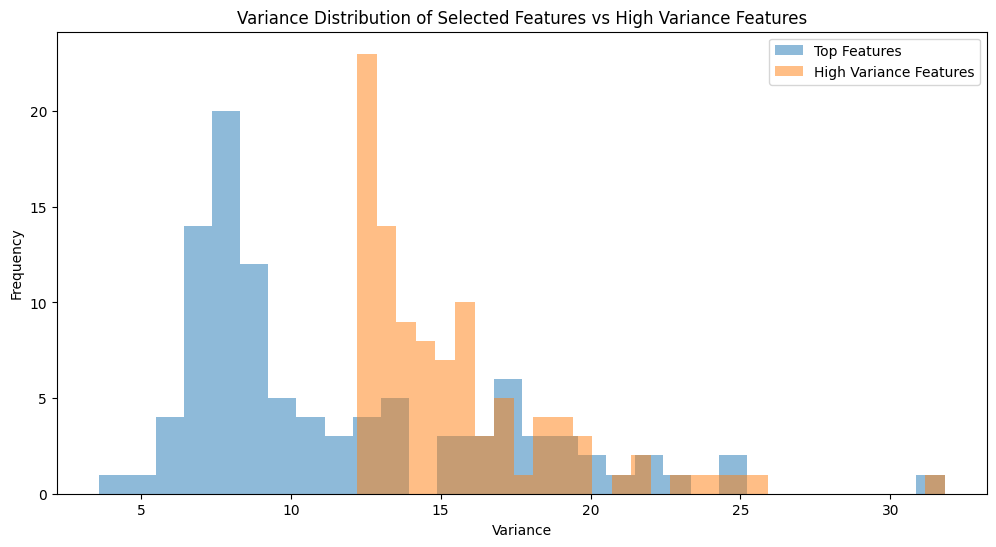

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the evaluation data
X_train_eval = np.load('./gene_analysis_data/p2_evaluation/X_train.npy')
y_train_eval = np.load('./gene_analysis_data/p2_evaluation/y_train.npy')
X_test_eval = np.load('./gene_analysis_data/p2_evaluation/X_test.npy')
y_test_eval = np.load('./gene_analysis_data/p2_evaluation/y_test.npy')

# Apply log2(x+1) transformation
X_train_eval_log = np.apply_along_axis(lambda x: np.log2(x + 1), 1, X_train_eval)
X_test_eval_log = np.apply_along_axis(lambda x: np.log2(x + 1), 1, X_test_eval)

# Use the previously computed top_features_indices to select the top features
# Assuming top_features_indices is already defined from the previous logistic regression model
# For demonstration purposes, I will use random indices if not defined
np.random.seed(42)
if 'top_features_indices' not in locals():
    top_features_indices = np.random.choice(X_train_eval_log.shape[1], 100, replace=False)

X_train_eval_top = X_train_eval_log[:, top_features_indices]
X_test_eval_top = X_test_eval_log[:, top_features_indices]

# Train logistic regression model with top features
model_eval = LogisticRegression(max_iter=1000, random_state=42)
model_eval.fit(X_train_eval_top, y_train_eval)

# Predict and evaluate with top features
y_pred_eval = model_eval.predict(X_test_eval_top)
accuracy_eval = accuracy_score(y_test_eval, y_pred_eval)
print(f"Evaluation Accuracy with Top Features: {accuracy_eval:.4f}")

# Compare with Random Features
random_features_indices = np.random.choice(X_train_eval_log.shape[1], 100, replace=False)
X_train_eval_random = X_train_eval_log[:, random_features_indices]
X_test_eval_random = X_test_eval_log[:, random_features_indices]

model_random = LogisticRegression(max_iter=1000, random_state=42)
model_random.fit(X_train_eval_random, y_train_eval)

y_pred_random = model_random.predict(X_test_eval_random)
accuracy_random = accuracy_score(y_test_eval, y_pred_random)
print(f"Evaluation Accuracy with Random Features: {accuracy_random:.4f}")

# Compare with High-Variance Features
variances = np.var(X_train_eval_log, axis=0)
high_variance_indices = np.argsort(variances)[-100:]

X_train_eval_high_var = X_train_eval_log[:, high_variance_indices]
X_test_eval_high_var = X_test_eval_log[:, high_variance_indices]

model_high_var = LogisticRegression(max_iter=1000, random_state=42)
model_high_var.fit(X_train_eval_high_var, y_train_eval)

y_pred_high_var = model_high_var.predict(X_test_eval_high_var)
accuracy_high_var = accuracy_score(y_test_eval, y_pred_high_var)
print(f"Evaluation Accuracy with High Variance Features: {accuracy_high_var:.4f}")

# Variance Comparison
selected_feature_variances = variances[top_features_indices]
high_variance_feature_variances = variances[high_variance_indices]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(selected_feature_variances, bins=30, alpha=0.5, label='Top Features')
plt.hist(high_variance_feature_variances, bins=30, alpha=0.5, label='High Variance Features')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Variance Distribution of Selected Features vs High Variance Features')
plt.show()


/tmp/ipykernel_6007/4279066309.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_results[num_pcs][:, 0], tsne_results[num_pcs][:, 1], s=5, cmap='viridis')


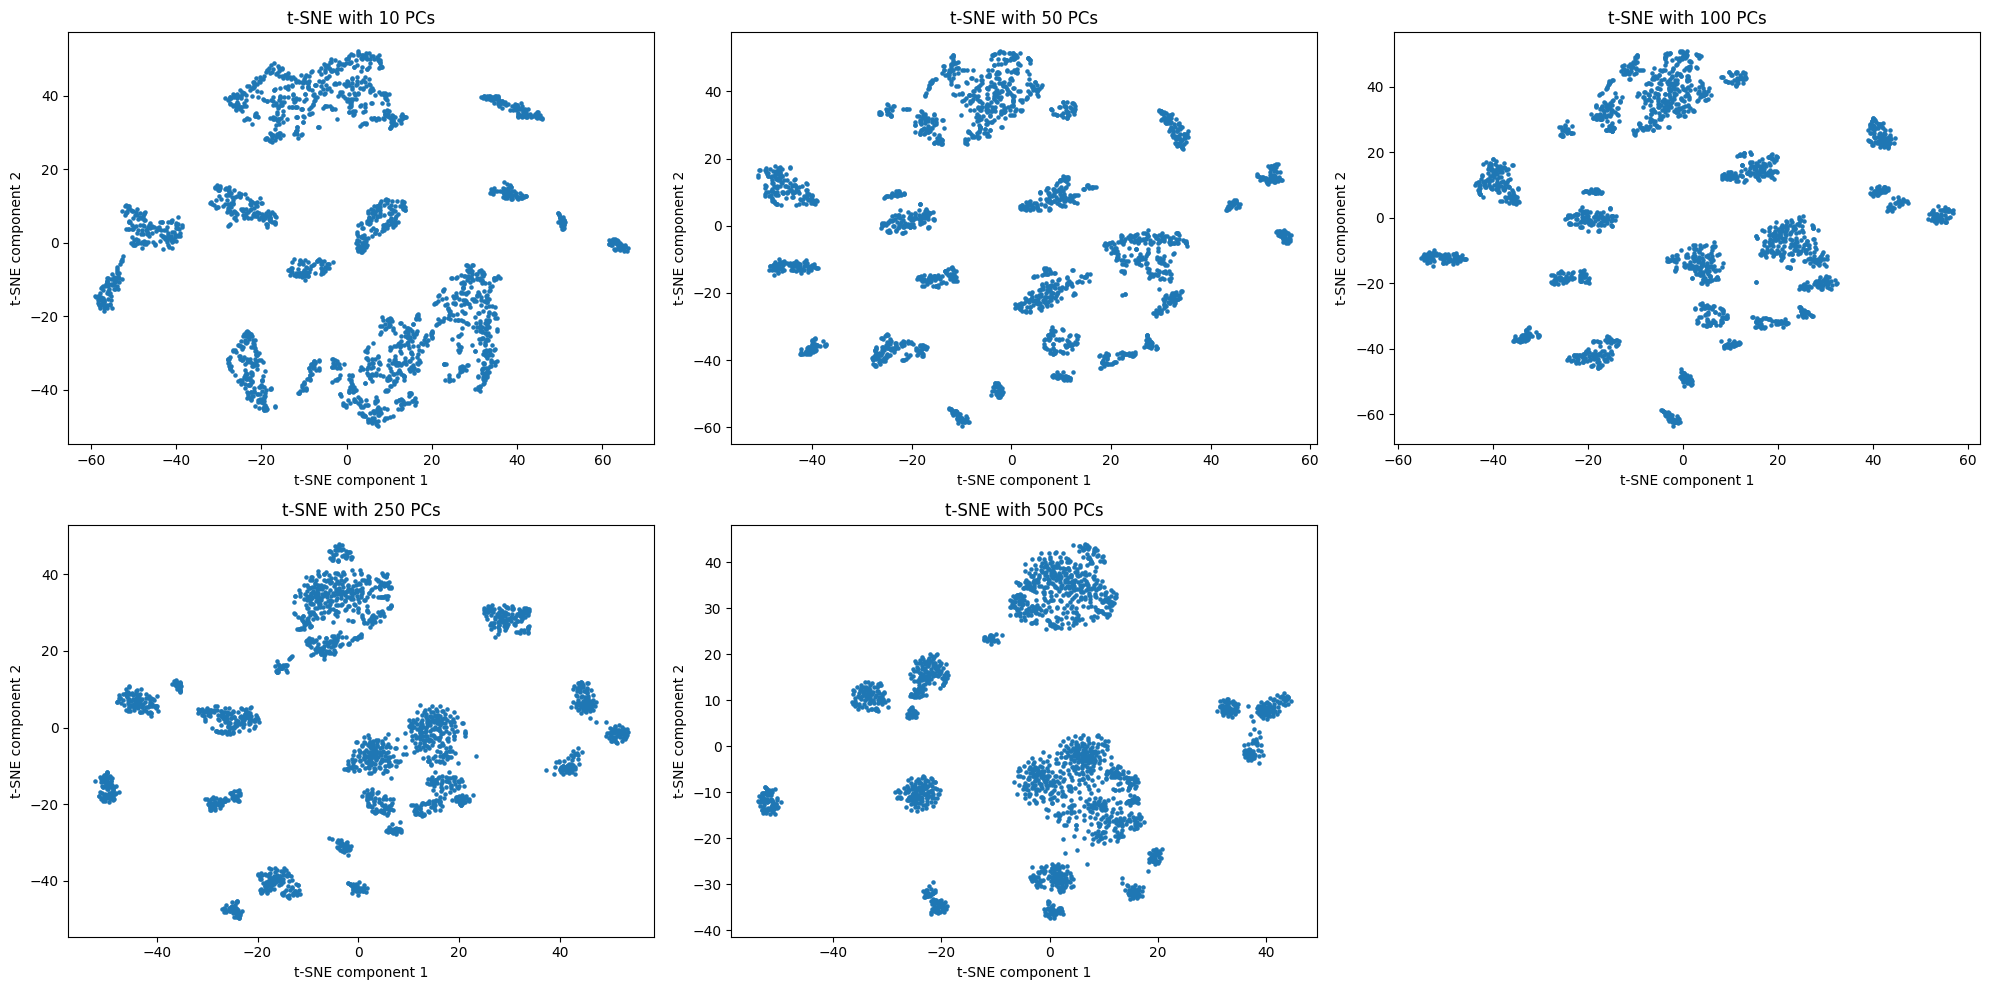

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define the number of principal components to use
num_pcs_list = [10, 50, 100, 250, 500]

# Initialize a dictionary to store the PCA results
pca_results = {}

for num_pcs in num_pcs_list:
    pca = PCA(n_components=num_pcs)
    pca_results[num_pcs] = pca.fit_transform(X)

# Initialize a dictionary to store the t-SNE results
tsne_results = {}

# Apply t-SNE
for num_pcs, pca_data in pca_results.items():
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_results[num_pcs] = tsne.fit_transform(pca_data)

# Plot the t-SNE results
plt.figure(figsize=(20, 10))

for i, num_pcs in enumerate(num_pcs_list):
    plt.subplot(2, 3, i + 1)
    plt.scatter(tsne_results[num_pcs][:, 0], tsne_results[num_pcs][:, 1], s=5, cmap='viridis')
    plt.title(f't-SNE with {num_pcs} PCs')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

plt.tight_layout()
plt.show()

/tmp/ipykernel_6007/3879888533.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_perplexity_results[perplexity][:, 0], tsne_perplexity_results[perplexity][:, 1], s=5, cmap='viridis')


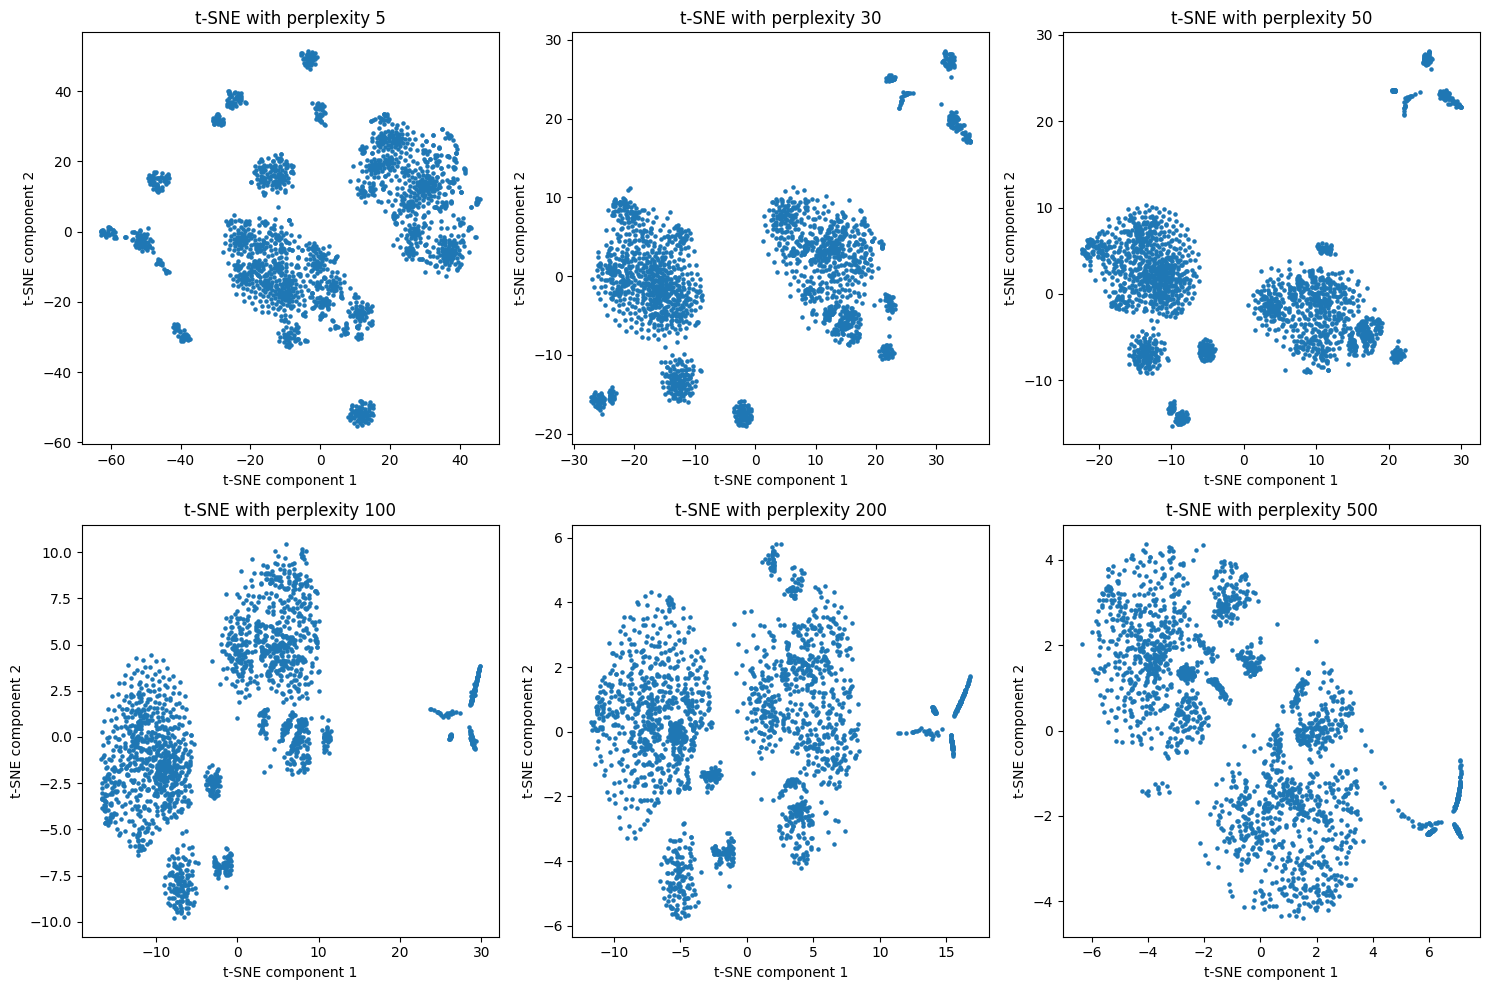

In [20]:
perplexities = [5, 30, 50, 100, 200, 500]
tsne_perplexity_results = {}

for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=42)
    tsne_perplexity_results[perplexity] = tsne.fit_transform(X)

# Plotting the t-SNE results for different perplexities
plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities):
    plt.subplot(2, 3, i + 1)
    plt.scatter(tsne_perplexity_results[perplexity][:, 0], tsne_perplexity_results[perplexity][:, 1], s=5, cmap='viridis')
    plt.title(f't-SNE with perplexity {perplexity}')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

plt.tight_layout()
plt.show()


/tmp/ipykernel_6007/790587787.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_learning_rate_results[learning_rate][:, 0], tsne_learning_rate_results[learning_rate][:, 1], s=5, cmap='viridis')


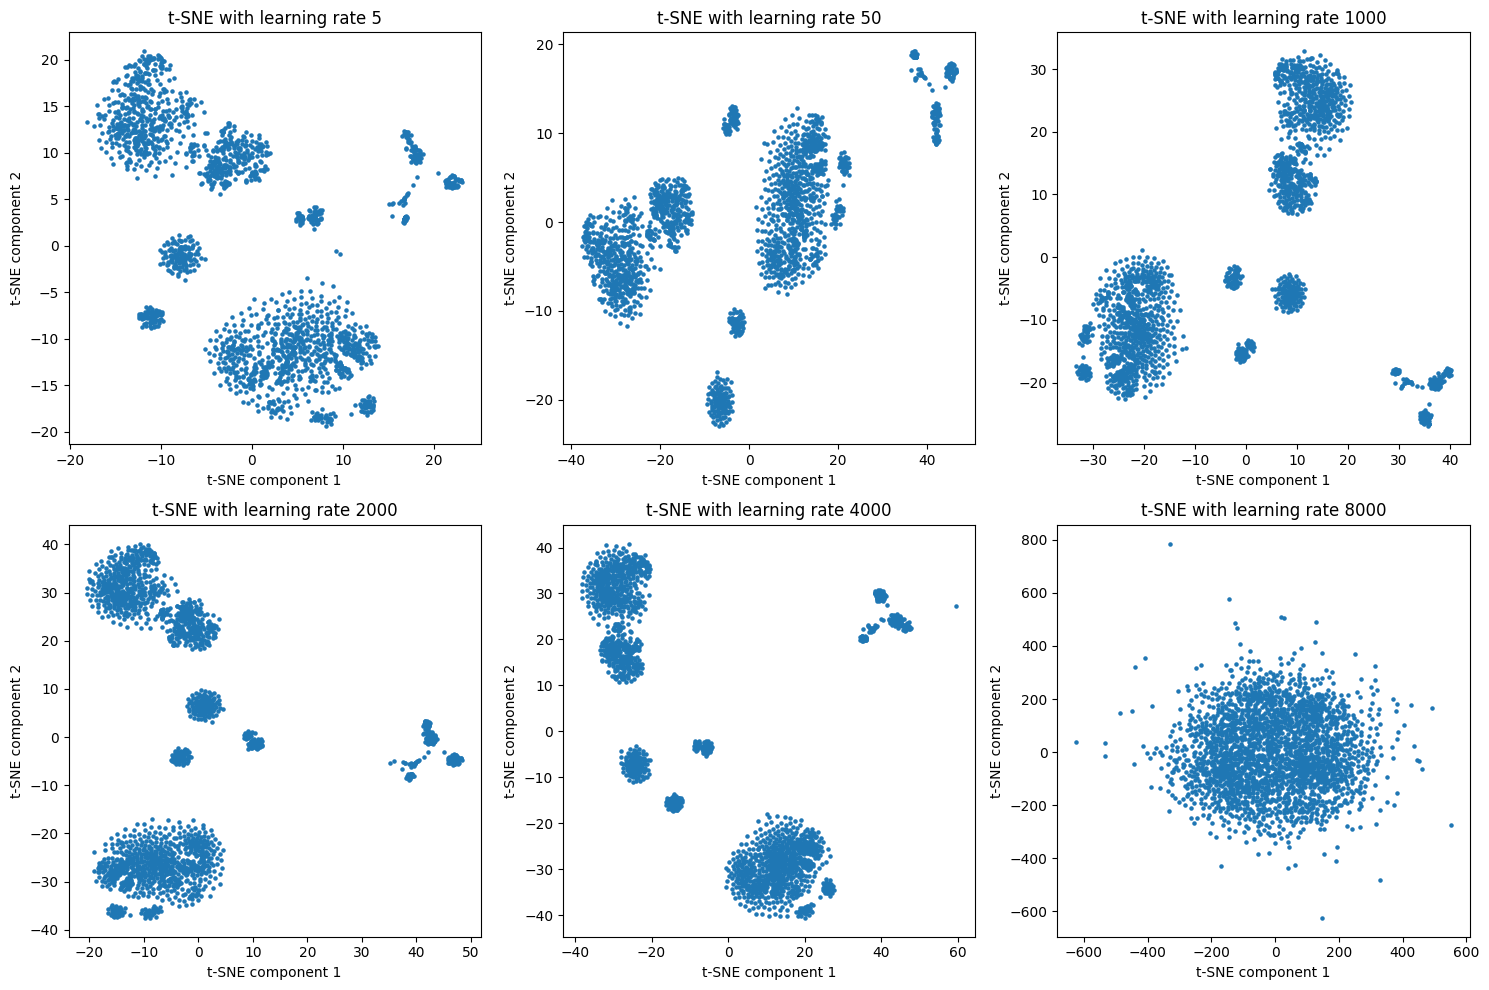

In [27]:
learning_rates = [5, 50, 1000, 2000, 4000, 8000]
tsne_learning_rate_results = {}

for learning_rate in learning_rates:
    tsne = TSNE(n_components=2, learning_rate=learning_rate, perplexity=40, n_iter=1000, random_state=42)
    tsne_learning_rate_results[learning_rate] = tsne.fit_transform(X_PCA)

# Plotting the t-SNE results for different learning rates
plt.figure(figsize=(15, 10))

for i, learning_rate in enumerate(learning_rates):
    plt.subplot(2, 3, i + 1)
    plt.scatter(tsne_learning_rate_results[learning_rate][:, 0], tsne_learning_rate_results[learning_rate][:, 1], s=5, cmap='viridis')
    plt.title(f't-SNE with learning rate {learning_rate}')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

plt.tight_layout()
plt.show()


In [28]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

num_clusters_list = [3, 4, 6, 8, 10, 20, 30]
cluster_results = {}

for num_clusters in num_clusters_list:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_PCA)

    # Train logistic regression model using cluster labels
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X, clusters)

    # Select top 100 features based on logistic regression coefficients
    coef_sums = np.sum(np.abs(model.coef_), axis=0)
    top_features_indices = np.argsort(coef_sums)[-100:]

    # Evaluate on evaluation data
    X_train_eval_top = X_train_eval_log[:, top_features_indices]
    X_test_eval_top = X_test_eval_log[:, top_features_indices]

    model_eval = LogisticRegression(max_iter=1000, random_state=42)
    model_eval.fit(X_train_eval_top, y_train_eval)

    y_pred_eval = model_eval.predict(X_test_eval_top)
    accuracy_eval = accuracy_score(y_test_eval, y_pred_eval)
    cluster_results[num_clusters] = accuracy_eval

print("Evaluation Accuracies with Different Number of Clusters for Feature Selection:")
for num_clusters, accuracy in cluster_results.items():
    print(f"Number of clusters: {num_clusters}, Accuracy: {accuracy:.4f}")


/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ha/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ha

Evaluation Accuracies with Different Number of Clusters for Feature Selection:
Number of clusters: 3, Accuracy: 0.9043
Number of clusters: 4, Accuracy: 0.8863
Number of clusters: 6, Accuracy: 0.9179
Number of clusters: 8, Accuracy: 0.9242
Number of clusters: 10, Accuracy: 0.9197
Number of clusters: 20, Accuracy: 0.9323
Number of clusters: 30, Accuracy: 0.9296
